### Задание

Предложены данные сети кофеен, где целевой переменной выступает **средний товарооборот** за определенный промежуток времени (переменная `target`). Значения этой переменной известны для **обучающей выборки** и отсутствуют для **тестовой выборки**.

### Данные для каждой кофейни включают:

1. **Идентификатор** (`id`).
2. **Расстояние до метро**.
3. **Признаки, характеризующие окружающие объекты**:
   - Количество отзывов, количество объектов, средний рейтинг объектов в указанном радиусе от кофейни.
   - Примечание: в категорию «Кофейни» не включена рассматриваемая кофейня.

4. **Признаки интенсивности транспортных и пешеходных потоков**:
   - Оценка интенсивности для пешеходов, автомобилей и их суммы.
   - Учитывается разное время суток (утро, день, вечер, весь день).
   - Оценка рассчитана для числа сигналов и числа пользователей (юзеров), отдельно для резидентов и работников района, где расположена кофейня.

5. **Признаки, характеризующие жилые дома**:
   - Число квартир и цена квадратного метра в радиусе или пешей доступности от кофейни.

6. **Признаки мобильного трафика**:
   - Разделение трафика по возрасту, доходу, а также типу трафика (домашний, рабочий, транзитный, длительный) для района кофейни, включая их сумму.

7. **Тип кофейни**:
   - Бинарная переменная, определяющая расположение кофейни: в бизнес-центре, транспортном узле (хаб), на улице или в торговом центре.

8. **Примечание**:
   - Методы `heaviside` и `gauss` в названии признаков относятся к методике расчета расстояния.

### Задача

Создайте модель, которая **наиболее точно прогнозирует товарооборот кофеен**. При построении модели рекомендуется учитывать **бизнес-смысл** в отрасли, а также то, что **среди посетителей кофейни преобладают женщины**.

### Требования к модели

- **Ключевая метрика**: MAPE (Mean Absolute Percentage Error).
- Выведите значение MAPE на **кросс-валидации** на обучающей выборке.
- Заполните значениями, спрогнозированными на тестовой выборке, приложенную форму.


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

In [95]:
df = pd.read_excel('data/dataset.xlsx')
df_copy = df.copy()  


**Обработка `null`-значений**:
   - Определим все столбцы, где присутствуют `null`-значения.

   - Для каждой колонки с `null`-значениями выделим первое слово из названия, которое будем использовать в качестве критерия для группировки.

   - Сгруппируем столбцы на основе выделенных первых слов, чтобы понять природу `null`-значений.


In [97]:
columns_with_null = df.columns[df.isnull().any()]
columns_with_null

Index(['target', 'Среднее кол-во отзывов в категории "АЗС" в радиусе 150м',
       'Среднее кол-во отзывов в категории "Алкомаркеты" в радиусе 150м',
       'Среднее кол-во отзывов в категории "Аптеки" в радиусе 150м',
       'Среднее кол-во отзывов в категории "Банки" в радиусе 150м',
       'Среднее кол-во отзывов в категории "Бизнес_центры" в радиусе 150м',
       'Среднее кол-во отзывов в категории "ВУЗы" в радиусе 150м',
       'Среднее кол-во отзывов в категории "Вокзалы" в радиусе 150м',
       'Среднее кол-во отзывов в категории "Детскиемагазины" в радиусе 150м',
       'Среднее кол-во отзывов в категории "Жилыедома" в радиусе 150м',
       ...
       'Максимальный  автомобильный трафик юзеров рабочих в радиусе 140м',
       'Максимальный  пешеходный трафик юзеров рабочих в радиусе 140м',
       'Средний утренний автомобильный трафик юзеров рабочих в радиусе 140м',
       'Средний дневной автомобильный трафик юзеров рабочих в радиусе 140м',
       'Средний вечерний автомобильны

In [86]:
null_columns = df.isnull().sum()
null_columns = null_columns[null_columns > 0]

# Разделение столбцов с null на категории по первому слову в названии
# Извлечение первого слова из названия каждого столбца и группировка
null_column_first_words = null_columns.index.to_series().str.split().str[0]
null_columns_by_first_word = null_columns.index.to_series().groupby(null_column_first_words).apply(list)

null_columns_counts_by_first_word = null_column_first_words.value_counts()

null_columns_counts_by_first_word

Среднее         378
Средний         261
Максимальный     72
Средняя           5
target            1
Name: count, dtype: int64

**Пропуски в расчетах средних значений**:
   - Пропуски чаще всего появляются в столбцах, где подсчитываются различные средние показатели.
   - Основная причина возникновения `null` в этих столбцах — деление на ноль.
   - Логичным решением будет заполнение таких пропусков значением `0`.

**Пропуски в столбцах с максимальным трафиком**:
   - Столбцы с пропусками, содержащие слово "Максимальный", относятся к автомобильному и пешеходному трафику в разные временные периоды.
   - Большинство пропусков в этих столбцах, вероятно, связано с отсутствием данных.
   - Учитывая, что приоритет имеет оценка общей и повседневной активности (суммарный и средний трафик), а не пиковая нагрузка, можно удалить эти столбцы без значительных потерь для анализа.

**Удаление строк с пропусками в целевой переменной**:
   - Строки с `null`-значениями в целевой переменной `target` следует удалить из данных, на которых планируется обучать модель.

**Удаление колонок "Среднее количество объектов"**:
   - В данных имеются колонки `'Среднее количество объектов'`, которые не имеют практического смысла (значения в них всегда должны быть равны `1`), их также удалим из дальнейшего анализа.

**Удаление признаков с нулевой дисперсией**:
   - Кроме того, удалим из данных и другие признаки с нулевой дисперсией, так как они не влияют на обучение модели.

In [87]:
df = df.drop(columns=[col for col in df.columns if "Максимальный" in col and df[col].isnull().any()])

df = df.drop(columns=[col for col in df.columns if 'Среднее количество объектов' in col])

df_predict = df[df['target'].isnull()]
df = df.dropna(subset=['target'])

df_predict = df_predict.fillna(0)
df = df.fillna(0)

variances = df.var()
zero_variance_features = variances[variances == 0].index.tolist()
if zero_variance_features:
    df = df.drop(columns=zero_variance_features)
    
df.shape[1]

1964

Заметим, что в данных присутствуют признаки, **вложенные друг в друга**. Например, такие признаки, как:

- "Суммарное количество отзывов в радиусе 300м"
- "Суммарное количество отзывов в радиусе 150м"

Такая структура данных может создавать **избыточность** информации, что может негативно сказаться на качестве модели, приводя к излишней сложности и возможному переобучению.

Поэтому оставим только признаки, относящиеся к нахождению в **непосредственной близости** от изучаемого объекта (радиус 150 метров). Это соответствует примерно **2-минутной зоне доступности**, что является адекватным выбором с точки зрения бизнес-логики.

Особое внимание следует уделить **данным об окружающих кофейнях**, поскольку из-за конкурентного фактора кофейни, как правило, не открываются в непосредственной близости от уже существующих заведений. В связи с этим, данных в радиусе 150 метров может быть недостаточно для полноценного анализа конкурентной среды.


In [89]:
additional_columns = ['id', 'target', 'Тип БЦ', 'Расстояние до метро', 'Тип хаб', 'Тип улица', 'Тип ТЦ']
radius_list = ['в радиусе 500м', 'в радиусе 300м', 'в радиусе 700м']

filtered_columns_final = ([col for col in df.columns if
                           'в радиусе 150м' in col]
                          + [col for col in df.columns if any(r in col for r in radius_list) and 'Кофейня' in col]
                          + additional_columns)

filtered_df_final = df[filtered_columns_final]

filtered_df_final.shape[1]

320

Забегая вперед, стоит отметить, что обучение модели также проводилось на данных **без фильтрации по радиусу**, однако значение MAPE при этом оказалось выше. _(На иллюстрациях ниже представлены значение MAPE и top15 важных признаков)_

![Значение MAPE](data/image/MAPE_без_фильтрации.jpg)
![Топ 15 важных признаков](data/image/Top15_без_фильтрации.jpg)

Другой вариант заключался в использовании **средневзвешенных значений** (чем меньше радиус, тем больше вес). Однако и в этом случае MAPE оказался еще выше. _(На иллюстрациях ниже представлены значение MAPE и top15 важных признаков)_ 
![Значение MAPE](data/image/MAPE_средневзвешанное.jpg)
![Топ 15 важных признаков](data/image/Top15_средневзвешанное.jpg)

В финальной версии модели **MAPE = 6.5%**








Итак, у нас небольшое количество наблюдений и много признаков.
Еще один недостаток наших данных — это **высокая корреляция между признаками**. Для уменьшения размерности можно рассмотреть несколько подходов:

**PCA (Principal Component Analysis)**:
   - Преобразует признаки в новые компоненты, однако основной недостаток для нашей задачи — потеря интерпретации признаков.

**SelectKBest**:
   - Оценивает каждый признак индивидуально, основываясь на его статистической зависимости с целевой переменной. Однако этот метод не учитывает корреляцию между признаками, что может привести к выбору нескольких сильно коррелированных признаков и, как следствие, к избыточности в данных.

Поэтому я выбрала третий подход: **удаление сильно коррелированных признаков**. При этом из двух высококоррелирующих признаков удаляется тот, который имеет меньшую корреляцию с целевой переменной `target`.







In [90]:
def remove_highly_correlated_features(X, target, threshold=0.9, exclude_features=None):
   
    if exclude_features is None:
        exclude_features = []
        
    # Список признаков для исключения из расчётов корреляции
    exclude_features = [col for col in exclude_features if col in X.columns]

    X_corr = X.drop(columns=exclude_features)
    feature_target_corr = X_corr.corrwith(target).abs()

    corr_matrix = X_corr.corr().abs()
    
    # Создаем верхний треугольник матрицы корреляций
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    high_corr_pairs = (
        upper_tri.stack()
        .reset_index()
        .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
    )

    high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > threshold]

    to_drop = set()

    for index, row in high_corr_pairs.iterrows():
        feature1 = row['Feature1']
        feature2 = row['Feature2']

        if feature_target_corr[feature1] >= feature_target_corr[feature2]:
            to_drop.add(feature2)
        else:
            to_drop.add(feature1)

    X_reduced = X_corr.drop(labels=to_drop, axis=1)

    X_reduced = pd.concat([X_reduced, X[exclude_features]], axis=1)

    return X_reduced

X = filtered_df_final.drop(columns=['id', 'target'])
y = filtered_df_final['target']

target = filtered_df_final['target']

X = remove_highly_correlated_features(X, target, threshold=0.9)
print("Количество признаков после удаления сильно коррелирующих:", X.shape[1])

Количество признаков после удаления сильно коррелирующих: 131


Поскольку целевая переменная является непрерывной, для задачи подойдут следующие модели:

#### Линейная регрессия с регуляризацией (например, Lasso или Ridge)
- **Преимущества:**
  - **Линейные зависимости:** Предполагает линейные зависимости между признаками и целевой переменной.
  - **Регуляризация:** Методы регуляризации (Lasso или Ridge) помогают снизить переобучение и учитывать только значимые признаки.

- **Недостатки:**
  - **Ограниченная точность:** Может ограничивать точность при более сложных зависимостях между признаками и целевой переменной.
  - **Необходимость проверок:** Требуются дополнительные проверки на нормальность данных и гомоскедастичность остатков.

#### Градиентный бустинг с регуляризацией
- **Преимущества:**
  - **Нелинейные зависимости:** Подходит для сложных задач с нелинейными зависимостями между признаками и целевой переменной.
  - **Высокая точность:** Позволяет добиться высокой точности благодаря построению ансамбля деревьев.

- **Недостатки:**
  - **Настройка гиперпараметров:** Требует тщательной настройки гиперпараметров для достижения оптимальной производительности.
  - **Интерпретация результатов:** Сложнее интерпретировать результат по сравнению с моделями типа Random Forest, которые предоставляют важность признаков.
  - **Особенности оценки MAPE:** В отличие от среднеквадратичной ошибки (MSE), где градиенты пропорциональны разнице между фактическими и предсказанными значениями, в MAPE градиенты нормализуются на фактическое значение \( y_i \), что делает обучение чувствительным к малым значениям \( y_i \).

#### Random Forest
- **Преимущества:**
  - **Большое количество признаков:** Эффективно справляется с большим количеством признаков, не требуя строгого отбора.
  - **Снижение влияния неинформативных признаков:** Случайный выбор признаков на каждом шаге снижает влияние неинформативных признаков.
  - **Мультиколлинеарность:** Менее чувствителен к мультиколлинеарности по сравнению с линейной регрессией.
  - **Распределение данных:** Не требует, чтобы данные были нормально распределены или чтобы ошибки имели постоянную дисперсию.
  - **Нелинейные зависимости:** Хорошо справляется с нелинейными зависимостями между признаками и целевой переменной.
  - **Простота настройки:** Простая настройка и регуляризация модели.

- **Недостатки:**
  - **Проклятие размерности:** Может столкнуться с «проклятием размерности» при большом количестве признаков и малом объёме данных, что снижает эффективность модели.

Таким образом, для нашей задачи оптимальнее выбрать **Random Forest**


Лучшие параметры: {'max_depth': 5, 'n_estimators': 200}
MAPE на тестовых данных: 0.06532183746992938


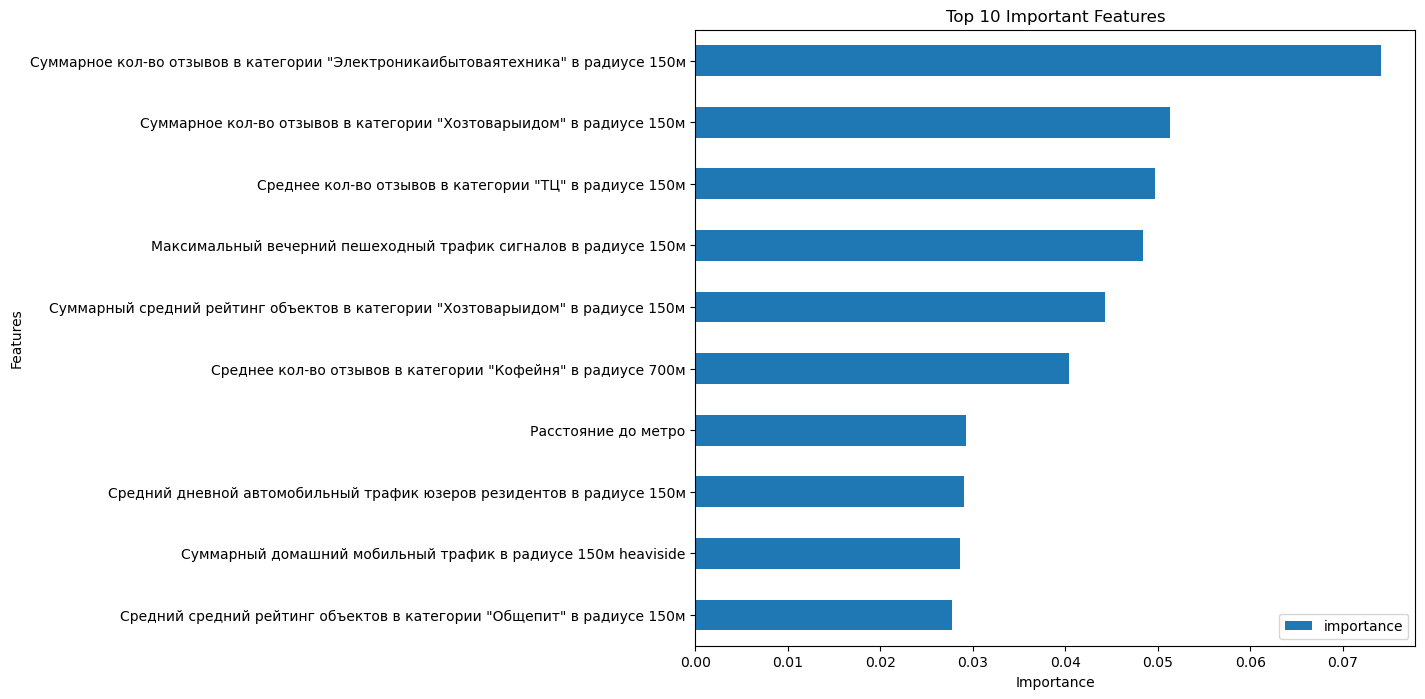

In [91]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(random_state=42)
parameters = {'n_estimators': [100, 150, 200], 'max_depth': [5, 10, 15, 20]}

scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

grid_search = GridSearchCV(model, parameters, scoring=scorer, cv=5)

grid_search.fit(X_train_clean, y_train_clean)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

y_pred = grid_search.predict(X_test_clean)

mape = mean_absolute_percentage_error(y_test_clean, y_pred)
print(f"MAPE на тестовых данных: {mape}")

best_model = grid_search.best_estimator_

importances = best_model.feature_importances_

feature_importances = pd.DataFrame({
    'Признак': X_train_clean.columns,
    'Важность': importances
})

feature_importances = feature_importances.sort_values(by='Важность', ascending=False)

imp = pd.DataFrame(best_model.feature_importances_, index=X_train_clean.columns, columns=['importance'])

top_10_imp = imp.sort_values(by='importance', ascending=False).head(10).sort_values('importance')


top_10_imp.plot(kind='barh', figsize=(12, 8))
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.subplots_adjust(left=0.3)  
plt.show()

**Результаты модели Random Forest**

Модель случайного леса продемонстрировала следующие результаты при прогнозировании товарооборота:

- **Метрика MAPE**: 6.5%, что является хорошим показателем для прогнозирования товарооборота.
- **Выделенные важные признаки**: модель подтвердила гипотезу о том, что основные посетители данной кофейни — **женщины**, что согласуется с фактическими наблюдениями.

Заполняем спрогнозированными на тестовой выборке при помощи полученной модели значениями приложенную форму.



In [92]:
extra_cols = set(df_predict.columns) - set(X.columns)
if extra_cols:
    df_predict = df_predict.drop(columns=extra_cols)

df_predict = df_predict[X.columns]

y_predict = best_model.predict(df_predict)

df_predict['target_predicted'] = y_predict

df_copy.loc[df_copy['target'].isnull(), 'target'] = df_predict['target_predicted']

df_copy

,id,target,Расстояние до метро,"Суммарное кол-во отзывов в категории ""АЗС"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Алкомаркеты"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Аптеки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Банки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Бизнес_центры"" в радиусе 150м","Суммарное кол-во отзывов в категории ""ВУЗы"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Вокзалы"" в радиусе 150м",...,Суммарный вечерний трафик сигналов рабочих в радиусе 140м,Суммарный трафик сигналов рабочих в радиусе 140м,Суммарный утренний трафик юзеров рабочих в радиусе 140м,Суммарный дневной трафик юзеров рабочих в радиусе 140м,Суммарный вечерний трафик юзеров рабочих в радиусе 140м,Суммарный трафик юзеров рабочих в радиусе 140м,Тип БЦ,Тип хаб,Тип улица,Тип ТЦ
0,60,1.292717,5526.692151,0,274,56,156,249,0,0,...,33,187,3,6,3,6,0,0,1,0
1,50,1.674569,16243.183872,0,0,719,402,0,0,0,...,303,1302,9,12,11,15,0,0,0,1
2,17,1.140666,6401.230357,0,194,425,271,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,15,1.352501,2255.498620,0,0,0,0,1737,83,0,...,52,315,6,7,5,10,0,0,1,0
4,74,1.324726,5811.209297,0,0,71,0,0,0,0,...,257,1189,2,2,2,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,112,1.452392,19887.712950,0,0,193,32,0,0,0,...,185,1074,6,6,7,8,0,0,0,1
94,117,1.419989,485.615204,0,1258,237,103,372,60,0,...,351,1529,9,10,10,13,0,0,1,0
95,126,1.409854,2420.989438,0,146,346,16,20,0,0,...,129,437,8,10,6,14,0,0,1,0
96,144,1.302246,11997.377318,0,85,414,547,0,0,0,...,91,309,10,10,9,12,0,0,1,0
